# Gradient metrics 

To isolate CO<sub>2</sub> gradients driven by Southern Ocean fluxes, we examine CO<sub>2</sub> anomalies relative to a local reference, using potential temperature ($\theta$) to delineate boundaries in the vertical.
We define metrics quantifying the vertical and horizontal CO<sub>2</sub> gradients
- $\Delta_{\theta}\ce{CO}_2$ is the difference between the median value of CO<sub>2</sub> observed south of 45°S where $\theta$ < 280 K and that in the mid- to upper-troposphere, $\pu{295 K} < \theta < \pu{305 K}$.
- $\Delta_{y}\ce{CO}_2$ is the difference between CO<sub>2</sub> averaged across stations in the core latitudes of summertime CO<sub>2</sub>-drawdown and that at the South Pole Observatory (SPO).

The atmospheric inversion models explicitly simulate CO<sub>2</sub> tracers responsive only to ocean $(\ce{CO}_2^{ocn})$, land $(\ce{CO}_2^{lnd})$ and fossil fuel $(\ce{CO}_2^{ff})$ fluxes and subject to identical transport fields.
We take advantage of these tracers to demonstrate that the gradient metrics ($\Delta_{\theta}\ce{CO}_2$, $\Delta_{y}\ce{CO}_2$) are primarily responsive to local ocean influence.

Related analysis:
- [Seasonal amplitude of CO<sub>2</sub> in the column](gradients-seasonal-amplitude.ipynb)
- [Simulated profiles of CO<sub>2</sub> flavors](gradients-profiles.ipynb)
- [Vertical gradients in CH<sub>4</sub>](gradients-methane.ipynb)
- [Horizontal gradients in SF<sub>6</sub>](gradients-sf6.ipynb)
- [Assessment of sampling representativeness](gradients-aircraft-sampling.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import obs_aircraft
import emergent_constraint as ec
import datasets

import figure_panels
import util

In [3]:
clobber = False 
clobber_deep = False
constraint_type = 'ocean_constraint'
campaign_info = obs_aircraft.get_campaign_info(verbose=False)
model_input_lists = ec.get_model_tracer_lists(constraint_type)
model_input_lists

{'model_tracer_list': [('CT2017', 'CO2_OCN'),
  ('CT2019B', 'CO2_OCN'),
  ('CTE2018', 'CO2_OCN'),
  ('CTE2020', 'CO2_OCN'),
  ('MIROC', 'CO2_OCN'),
  ('CAMSv20r1', 'CO2_OCN'),
  ('s99oc_v2020', 'CO2_OCN'),
  ('s99oc_ADJocI40S_v2020', 'CO2_OCN'),
  ('s99oc_SOCCOM_v2020', 'CO2_OCN'),
  ('TM5-Flux-m0f', 'CO2_OCN'),
  ('TM5-Flux-mmf', 'CO2_OCN'),
  ('TM5-Flux-mrf', 'CO2_OCN'),
  ('TM5-Flux-mwf', 'CO2_OCN')],
 'model_tracer_ext_list': [('CT2017', 'CO2_LND+CO2_FFF'),
  ('CT2019B', 'CO2_LND+CO2_FFF'),
  ('CTE2018', 'CO2_LND+CO2_FFF'),
  ('CTE2020', 'CO2_LND+CO2_FFF'),
  ('CAMSv20r1', 'CO2_LND+CO2_FFF'),
  ('s99oc_v2020', 'CO2_LND+CO2_FFF'),
  ('s99oc_ADJocI40S_v2020', 'CO2_LND+CO2_FFF'),
  ('s99oc_SOCCOM_v2020', 'CO2_LND+CO2_FFF')],
 'model_list_sfco2_lnd': []}

In [4]:
air_parms = ec.get_parameters('default')
obj_srf = ec.whole_enchilada_srf(**model_input_lists)
obj_air = ec.whole_enchilada(clobber=clobber_deep, **model_input_lists)

loading pfp
loading medusa
loading obs


In [5]:
ds_obs = datasets.aircraft_profiles_seasonal()
ds_obs

loading obs


<xarray.Dataset>
Dimensions:              (theta: 11, season: 4)
Coordinates:
  * theta                (theta) float64 270.0 275.0 280.0 ... 310.0 315.0 320.0
  * season               (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables: (12/135)
    co2moms              (season, theta) float64 nan 0.7296 ... -0.09414
    co2moms_std          (season, theta) float64 nan 0.03203 ... -0.04042
    co2moms_std_std      (season, theta) float64 nan 0.07492 ... 0.1093 0.002141
    co2moms_med          (season, theta) float64 nan 0.729 ... -0.098 -0.134
    co2moms_med_std      (season, theta) float64 nan 0.1761 ... 0.05923 0.06578
    sf6panther           (season, theta) float64 nan -0.02056 ... -0.06098
    ...                   ...
    sf6mucats_med_std    (season, theta) float64 nan nan nan ... 0.07587 0.06884
    sf6                  (season, theta) float64 nan -0.02056 ... -0.06098
    sf6_std              (season, theta) float64 nan -0.01634 ... 0.0177 0.04356
    sf6_std_std          (season, theta) float64 nan 0.0276 ... 0.03067 0.04638
    sf6_med              (season, theta) float64 nan -0.03 ... -0.01 -0.05
    sf6_med_std          (season, theta) float64 nan 0.07522 ... 0.08252 0.1189

## Seasonal aircraft profiles

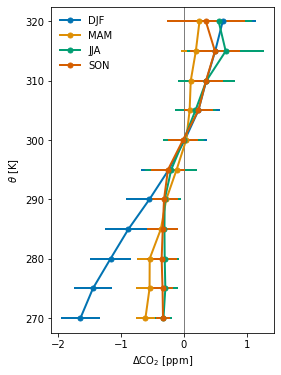

In [6]:
def plot_seasonal_profiles(ds_obs, ax):
    theta = ds_obs.theta
    seasons = ds_obs.season.values
    field = 'co2'
    for n, season in enumerate(seasons):
        dsi = ds_obs.sel(season=season)
        x, xerr = dsi[f'{field}_med'], dsi[f'{field}_med_std']
        ax.errorbar(x, theta, 
                    xerr=xerr, 
                    marker='.', 
                    label=season,
                    lw=2, 
                    c=figure_panels.palette_colors[n],
                    markersize=10, 
                    zorder=100,
                   )
    ax.axvline(0., lw=0.5, c='k')    
    ax.legend(frameon=False)    
    ax.set_ylabel('$\\theta$ [K]')
    ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
        
    xlm = ax.get_xlim()

fig, axs = util.canvas(1, 1, figsize=(4, 6))
plot_seasonal_profiles(ds_obs, axs[0, 0])

## Vertical gradients: ∆<sub>θ</sub>CO<sub>2</sub>

In [7]:
ac = obj_air.get_ac(**air_parms, clobber=clobber)
ac.vg_ext

computing...
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CT2017/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CT2019B/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CTE2018/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CTE2020/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/MIROC/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/co

co2  gradient_mean  gradient_std
model                 tracer  campaign                                       
s99oc_ADJocI40S_v2020 CO2     HIPPO-1  -0.904900      -0.904900           NaN
                              HIPPO-2  -0.289600      -0.289600           NaN
                              HIPPO-3  -0.825250      -0.825250           NaN
                              HIPPO-5  -0.433150      -0.433150           NaN
                              ORCAS-J  -0.882600      -0.882600           NaN
...                                          ...            ...           ...
CT2017                CO2_OCN ORCAS-F  -0.577625      -0.577625           NaN
                              ATOM-1   -0.022550      -0.022550           NaN
                              ATOM-2   -0.455355      -0.455355           NaN
                              ATOM-3         NaN            NaN           NaN
                              ATOM-4         NaN            NaN           NaN

[450 rows x 3 columns]

### Observed gradients

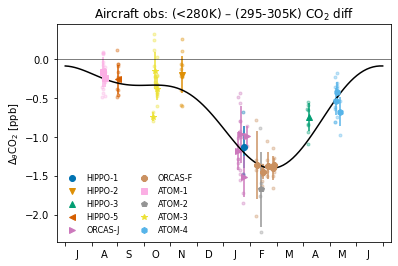

In [8]:
fig, axs = util.canvas(1, 1)
figure_panels.obs_theta_gradient(ac.flight_gradients, axs[0, 0], ac.theta_bins);

### Simulated gradients

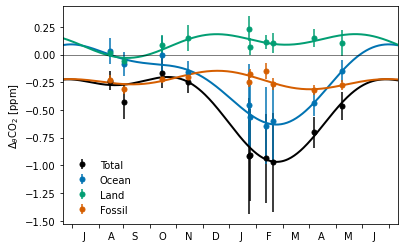

In [9]:
def vg_seasonal_cycle_model_flavors(ac, ax):

    df = ac.vg_ext
    co2_components = ['CO2', 'CO2_OCN', 'CO2_LND', 'CO2_FFF',]# 'CO2_LND+CO2_FFF']
   
    doy = []
    for c in campaign_info.keys():
        doy.append(util.day_of_year(np.array([campaign_info[c]['time']]))[0])

    data = {k: [] for k in co2_components}
    error = {k: [] for k in co2_components}
    for c in campaign_info.keys():    
        for tracer in co2_components:
            data[tracer].append(
                df.xs((c, tracer), level=('campaign', 'tracer')).gradient_mean.median()
            )
            error[tracer].append(
                df.xs((c, tracer), level=('campaign', 'tracer')).gradient_mean.std(ddof=1)
            )

    xhat = np.linspace(-30, 365+30, 365)

    for tracer in co2_components:
        x, y = util.antyear_daily(np.array(doy), np.array(data[tracer]))
        _, yerr = util.antyear_daily(np.array(doy), np.array(error[tracer]))
        ax.errorbar(x, y, yerr=yerr, 
                    linestyle='none', 
                    color=figure_panels.co2_colors[tracer], 
                    marker='.', 
                    markersize=10,
                    label=figure_panels.co2_names[tracer], 
                   )
        p, pcov = ec.curve_fit(ec.harmonic, xdata=x/365.25, ydata=y, sigma=yerr, absolute_sigma=True,)
        yhat = ec.harmonic(xhat/365.25, *p)
        ax.plot(xhat, yhat, color=figure_panels.co2_colors[tracer], lw=2)
        if tracer == 'CO2':
            yhat_out = yhat
            
    ax.axhline(0., lw=0.5, c='k')
    ax.legend(loc=(1.02, 0), ncol=1, fontsize=8);  
    ax.set_xlim((-10, 375))
    ax.set_xticks(figure_panels.bomday)
    ax.set_xticklabels([f'        {m}' for m in figure_panels.monlabs_ant]+['']);
    ax.legend(frameon=False)
    ax.set_ylabel('$\Delta_{ \\theta}$CO$_2$ [ppm]')
    return yhat_out

fig, axs = util.canvas(1, 1)
co2_air = vg_seasonal_cycle_model_flavors(ac, axs[0, 0]) 

## Horizontal gradients: ∆<sub>y</sub>CO<sub>2</sub>

In [10]:
data_a_clm = datasets.obs_surface_climatology('co2')
data_a_clm

<xarray.Dataset>
Dimensions:  (stncode: 8, month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * stncode  (stncode) object 'CRZ' 'MQA' 'DRP' 'PSA' 'SYO' 'CYA' 'MAA' 'HBA'
Data variables:
    lat      (stncode, month) float64 -46.43 -46.43 -46.43 ... -75.61 -75.61
    CO2      (stncode, month) float64 -0.4859 -0.3674 ... 0.009556 -0.1172
    CO2_std  (month) float64 0.1112 0.1557 0.09192 ... 0.0922 0.0766 0.09829

In [11]:
sc = obj_srf.get_sc(clobber=clobber)
sc.df_gradients_mon

computing...
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CT2017/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CT2019B/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CTE2018/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CTE2020/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/MIROC/flux_ts_monthly.lat_range=-90_0_to_-45_0.nc
assuming cache is correct
reading cached file: /glade/u/home/mclong/co

season   time_bounds  gradient  gradient_std
model  tracer  period    month                                             
obs    CO2     2000-2004 1        DJF  (2000, 2004) -0.262963      0.143441
               2005-2009 1        DJF  (2005, 2009) -0.191414      0.074473
               2010-2014 1        DJF  (2010, 2014) -0.297850      0.044947
               2015-2019 1        DJF  (2015, 2019) -0.346297      0.043477
               1999-2020 1        DJF  (1999, 2020) -0.254041      0.111184
...                               ...           ...       ...           ...
CT2017 CO2_OCN 2010-2014 12       DJF  (2010, 2014) -0.225140      0.039598
               2015-2019 12       DJF  (2015, 2019) -0.136412      0.121372
               1999-2020 12       DJF  (1999, 2020) -0.165964      0.086638
               1999-2009 12       DJF  (1999, 2009) -0.120906      0.059238
               2009-2020 12       DJF  (2009, 2020) -0.216655      0.084553

[3864 rows x 4 columns]

### Observed gradients

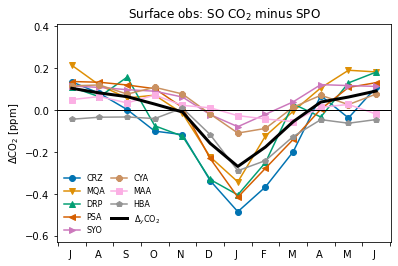

In [12]:
fig, axs = util.canvas(1, 1)
figure_panels.obs_srf_seasonal(axs[0, 0], data_a_clm)

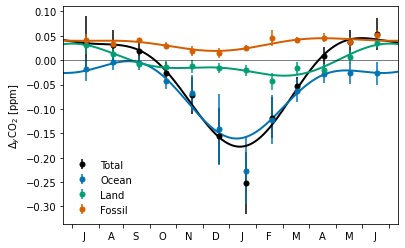

In [13]:
def hg_seasonal_cycle_model_flavors(sc, ax, period='1999-2020'):

    df = sc.df_gradients_mon
    co2_components = ['CO2', 'CO2_OCN', 'CO2_LND', 'CO2_FFF',]# 'CO2_LND+CO2_FFF']
   
    doy = util.doy_midmonth()

    data = {k: [] for k in co2_components}
    error = {k: [] for k in co2_components}
    for month in range(1, 13):
        for tracer in co2_components:
            gradient = df.xs((period, month, tracer), level=('period', 'month', 'tracer')).gradient
            data[tracer].append(gradient.median())
            error[tracer].append(gradient.std(ddof=1))
    
    xhat = np.linspace(-30, 365+30, 365)

    for tracer in co2_components:
        x, y = util.antyear_daily(np.array(doy), np.array(data[tracer]))
        _, yerr = util.antyear_daily(np.array(doy), np.array(error[tracer]))
        ax.errorbar(x, y, yerr=yerr, 
                    linestyle='none', 
                    color=figure_panels.co2_colors[tracer], 
                    marker='.', 
                    markersize=10,
                    label=figure_panels.co2_names[tracer], 
                   )
        p, pcov = ec.curve_fit(ec.harmonic, xdata=x/365.25, ydata=y, sigma=yerr, absolute_sigma=True,)
        yhat = ec.harmonic(xhat/365.25, *p)            
        ax.plot(xhat, yhat, color=figure_panels.co2_colors[tracer], lw=2)
        if tracer == 'CO2':
            yhat_out = yhat

    ax.axhline(0., lw=0.5, c='k')
    ax.legend(loc=(1.02, 0), ncol=1, fontsize=8);  
    ax.set_xlim((-10, 375))
    ax.set_xticks(figure_panels.bomday)
    ax.set_xticklabels([f'        {m}' for m in figure_panels.monlabs_ant]+['']);
    ax.legend(frameon=False)
    ax.set_ylabel('$\Delta_{ y}$CO$_2$ [ppm]')
    return yhat_out 

fig, axs = util.canvas(1, 1)
co2_srf = hg_seasonal_cycle_model_flavors(sc, axs[0, 0]) 

How much bigger is the vertical gradient?

In [14]:
(co2_air.max() - co2_air.min())/(co2_srf.max() - co2_srf.min())

3.4394685186874296

## Fig 2: Seasonal evolution atmospheric CO<sub>2</sub> gradients

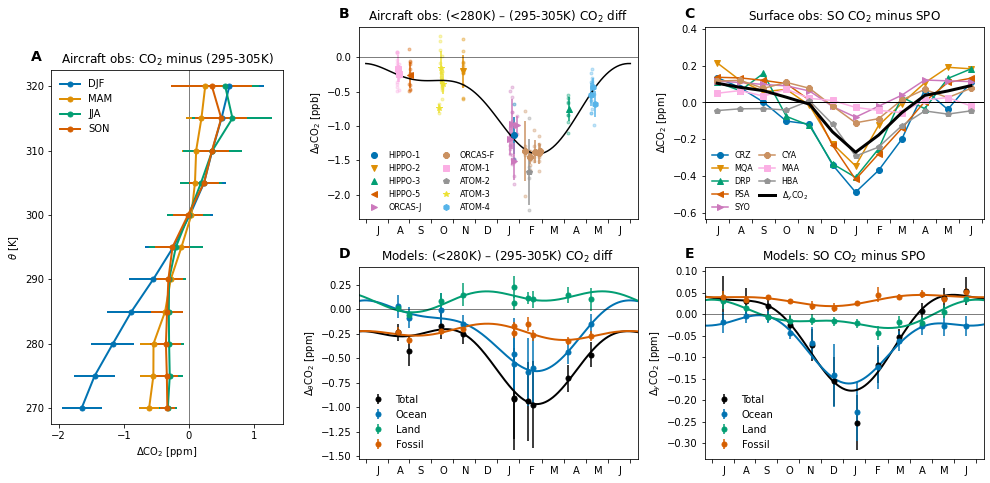

In [15]:
fig = plt.figure(figsize=(14, 6)) #dpi=300)

# set up plot grid
gs = gridspec.GridSpec(
    nrows=2, ncols=2, 
    left=0.38, right=1,
    bottom=0., top=1,
    hspace=0.25, wspace=0.24,
)

nrow = 2
ncol = 2
axs = np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):
    axs[i, j] = plt.subplot(gs[i, j])

ax_p = fig.add_axes([0.075, 0.08, 0.23, 0.82])
plot_seasonal_profiles(ds_obs, ax_p)
tbin = ac.theta_bins[0]
ax_p.set_title(f'Aircraft obs: CO$_2$ minus ({tbin[0]:0.0f}-{tbin[1]:0.0f}K)')
figure_panels.obs_theta_gradient(ac.flight_gradients, axs[0, 0], ac.theta_bins);
ylm = axs[0, 0].get_ylim()

theta_str = figure_panels.theta_bin_def(ac.theta_bins)
vg_seasonal_cycle_model_flavors(ac, axs[1, 0])
axs[1, 0].set_title(f'Models: {theta_str} CO$_2$ diff')

figure_panels.obs_srf_seasonal(axs[0, 1], data_a_clm)

hg_seasonal_cycle_model_flavors(sc, axs[1, 1])
axs[1, 1].set_title(f'Models: SO CO$_2$ minus SPO')

util.label_plots(fig, [ax_p]+[ax for ax in axs.ravel()], xoff=-0.02)

util.savefig(f'metrics-seasonal-cycle.pdf')

**Seasonal evolution of atmospheric CO<sub>2</sub> over the Southern Ocean.** (A) Vertical profiles of CO<sub>2</sub> observations collected by aircraft south of 45°S, binned on 5 K potential temperature (θ) bins and averaged by season (whiskers show standard deviation). (B) The vertical gradient ($\Delta_{\theta}\ce{CO}_2$) in CO<sub>2</sub> measured from aircraft south of 45°S. Small points show $\Delta_{\theta}\ce{CO}_2$ for individual profiles; larger points show the median and standard deviation (whiskers) for each flight. The black line shows a two-harmonic fit to the flight-median points. (C) Monthly climatology (1999–2019) of the latitudinal gradient in CO<sub>2</sub> measured by surface stations ([Fig 1](obs-main.ipynb)); the black line shows the station mean metric ($\Delta_{y}\ce{CO}_2$). Separate laboratory records at SYO and PSA have been averaged. The seasonal evolution of (D) $\Delta_{\theta}\ce{CO}_2$ and (E) $\Delta_{y}\ce{CO}_2$ simulated in a collection of atmospheric inverse models. The points show the median across the models, whiskers show the standard deviation; the colors correspond to the “total” CO<sub>2</sub> (black), and CO<sub>2</sub> tracers responsive to only ocean (blue), land (green), and fossil (red) surface fluxes. Note that the <i>y</i>-axis bounds differ by panel.